# Ideas and useful sources
## 1. Similar competitions
### - Smoker status:
### - https://www.kaggle.com/code/cv13j0/efficient-prediction-of-smoker-status
### - https://www.kaggle.com/code/arunklenin/ps3e24-eda-feature-engineering-ensemble
### -  https://www.kaggle.com/code/ravi20076/playgrounds3e24-eda-baseline
### - https://www.kaggle.com/code/oscarm524/ps-s3-ep24-eda-modeling-submission
### -  https://www.kaggle.com/code/ashishkumarak/binary-classification-smoker-or-not-eda-xgboost

## 2. Ideas and Tasks
### - Logging
### - Turning into classes and functions (config classes)
### - Optuna + model ensemble (use this notebook: https://www.kaggle.com/code/rzatemizel/ensemble-pipeline)
### - SHAP
### - Do the rest of feature engineering -> clustering, pca, count, aggregation etc.
### - Calculate baseline catboost with all provided columns, with selected from all provided, with all feature engineered, with selected feature engineering then finetune 
### -

In [601]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import datetime
from prettytable import PrettyTable

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, make_scorer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import VotingClassifier, HistGradientBoostingClassifier

import optuna
from optuna import Trial
from optuna import create_study
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from utils.eda import summary

In [372]:
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.2f}'.format

In [373]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [374]:
summary_df = summary(test_df)
summary_df

data shape: (110023, 13)
Number of duplicates found and removed: 0


,data type,#missing,%missing,#unique,min,max,average,standard_deviation,first value,second value,third value
id,int64,0,0.00,110023,"165,034.00","275,056.00","220,045.00","31,761.05",165034,165035,165036
CustomerId,int64,0,0.00,19698,"15,565,701.00","15,815,690.00","15,692,096.61","71,684.99",15773898,15782418,15807120
Surname,object,0,0.00,2708,NaN,NaN,NaN,NaN,Lucchese,Nott,K?
CreditScore,int64,0,0.00,454,350.00,850.00,656.53,80.32,586,683,656
Geography,object,0,0.00,3,NaN,NaN,NaN,NaN,France,France,France
Gender,object,0,0.00,2,NaN,NaN,NaN,NaN,Female,Female,Female
Age,float64,0,0.00,74,18.00,92.00,38.12,8.86,23.00,46.00,34.00
Tenure,int64,0,0.00,11,0.00,10.00,5.00,2.81,2,2,7
Balance,float64,0,0.00,22513,0.00,"250,898.09","55,333.61","62,788.52",0.00,0.00,0.00
NumOfProducts,int64,0,0.00,4,1.00,4.00,1.55,0.54,2,1,2


In [375]:
summary_df = summary(train_df)
summary_df

data shape: (165034, 14)
Number of duplicates found and removed: 0


,data type,#missing,%missing,#unique,min,max,average,standard_deviation,first value,second value,third value
id,int64,0,0.00,165034,0.00,"165,033.00","82,516.50","47,641.36",0,1,2
CustomerId,int64,0,0.00,23221,"15,565,701.00","15,815,690.00","15,692,005.02","71,397.82",15674932,15749177,15694510
Surname,object,0,0.00,2797,NaN,NaN,NaN,NaN,Okwudilichukwu,Okwudiliolisa,Hsueh
CreditScore,int64,0,0.00,457,350.00,850.00,656.45,80.10,668,627,678
Geography,object,0,0.00,3,NaN,NaN,NaN,NaN,France,France,France
Gender,object,0,0.00,2,NaN,NaN,NaN,NaN,Male,Male,Male
Age,float64,0,0.00,71,18.00,92.00,38.13,8.87,33.00,33.00,40.00
Tenure,int64,0,0.00,11,0.00,10.00,5.02,2.81,3,1,10
Balance,float64,0,0.00,30075,0.00,"250,898.09","55,478.09","62,817.66",0.00,0.00,0.00
NumOfProducts,int64,0,0.00,4,1.00,4.00,1.55,0.55,2,2,2


## 2. Numerical/Categorical Data Split

In [376]:
cat_cols = [column for column in train_df.columns if train_df[column].dtype == 'object']
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

num_cols.remove('id')
num_cols.remove('Exited')
num_cols.remove('CustomerId')
cat_cols.remove('Surname')

num_cols.remove('IsActiveMember')
cat_cols.append('IsActiveMember')

num_cols.remove('Tenure')
cat_cols.append('Tenure')

num_cols.remove('NumOfProducts')
cat_cols.append('NumOfProducts')

num_cols.remove('HasCrCard')
cat_cols.append('HasCrCard')

target_col = 'Exited'

train_df['HasCrCard'].astype('category')
train_df['IsActiveMember'].astype('category');

In [377]:
print(f'Category Columns: {cat_cols}')
print(f'Numerical Columns: {num_cols}')
print(f'Target Column: {target_col}')

Category Columns: ['Geography', 'Gender', 'IsActiveMember', 'Tenure', 'NumOfProducts', 'HasCrCard']
Numerical Columns: ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
Target Column: Exited


## 2. Target Distribution
Source: https://www.kaggle.com/code/arunklenin/ps4e1-advanced-feature-engineering-ensemble

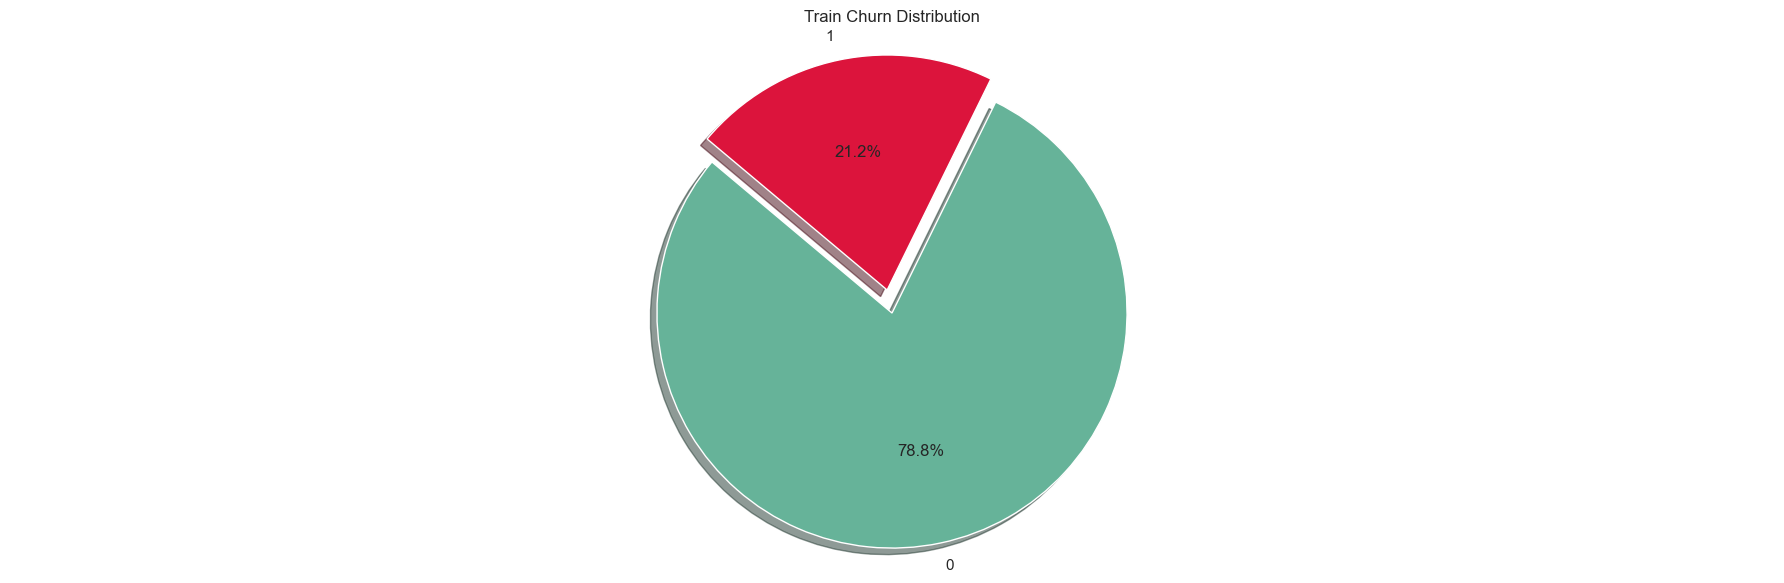

In [334]:
def plot_pie_chart(data, title, ax):
    data_counts = data[target_col].value_counts()
    labels = data_counts.index
    sizes = data_counts.values
    colors = [ (0.4, 0.7, 0.6), 'crimson']  
    explode = (0.1, 0)  

    ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal') 
    ax.set_title(title)

fig, axes = plt.subplots(1, 1, figsize=(18, 6))  # Create three subplots in a row

plot_pie_chart(train_df, "Train Churn Distribution", axes)

plt.tight_layout()
plt.show()

## 3. EDA Numerical Data Analysis 
Source: https://www.kaggle.com/code/arunklenin/ps4e1-advanced-feature-engineering-ensemble

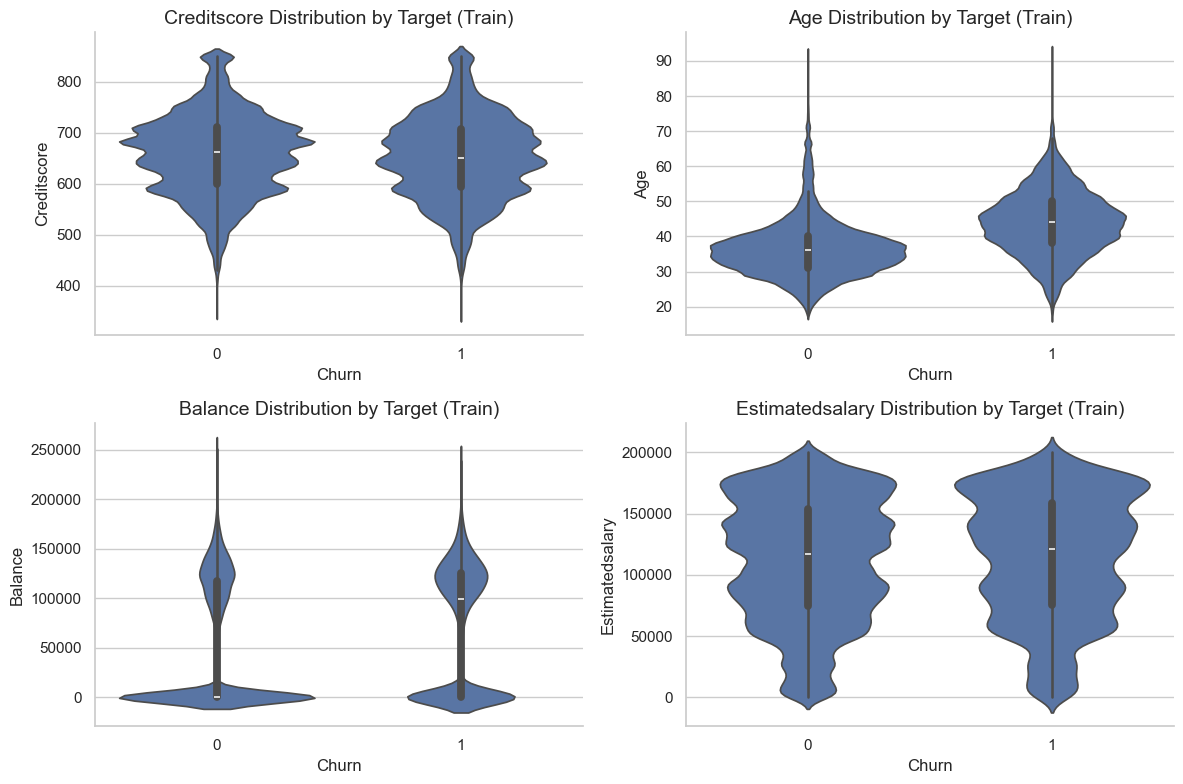

In [335]:
n_rows = len(num_cols)
n_cols = 2
fig, axs = plt.subplots(n_rows // n_cols, n_cols, figsize=(12, 4 * (n_rows // n_cols)))
sns.set_palette("Set3")

for i, col in enumerate(num_cols):
    row_idx = i // n_cols
    col_idx = i % n_cols

    sns.violinplot(x=target_col, y=col, data=train_df, ax=axs[row_idx, col_idx])
    axs[row_idx, col_idx].set_title(f'{col.title()} Distribution by Target (Train)', fontsize=14)
    axs[row_idx, col_idx].set_xlabel('Churn', fontsize=12)
    axs[row_idx, col_idx].set_ylabel(col.title(), fontsize=12)
    sns.despine()

fig.tight_layout()

plt.show()

## 4. EDA Categorical Data Analysis
Source: https://www.kaggle.com/code/arunklenin/ps4e1-advanced-feature-engineering-ensemble

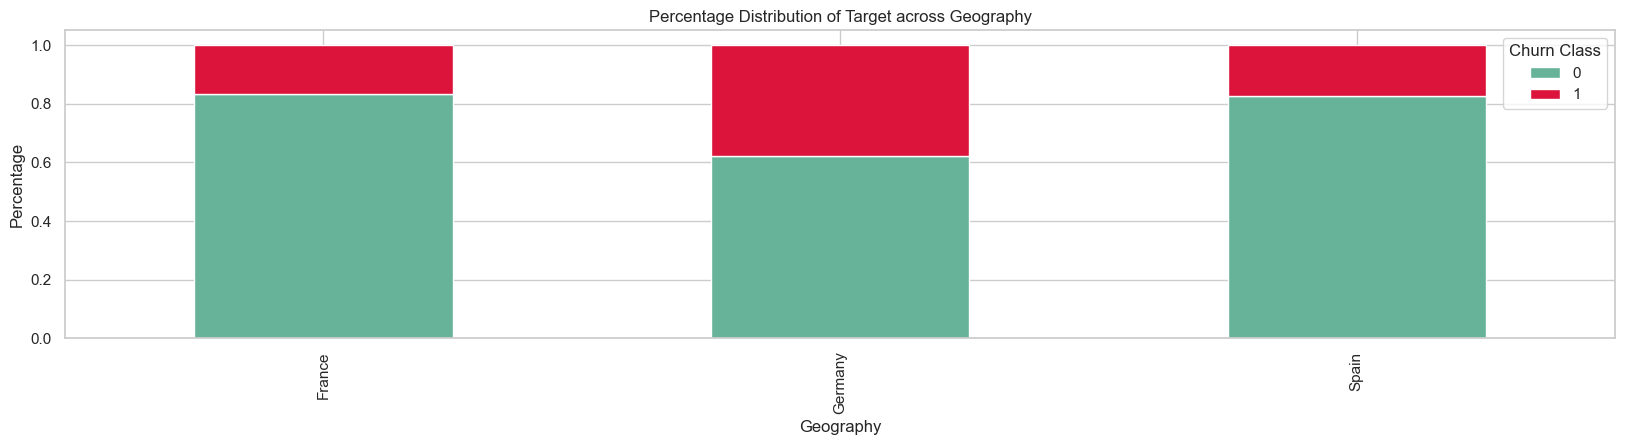

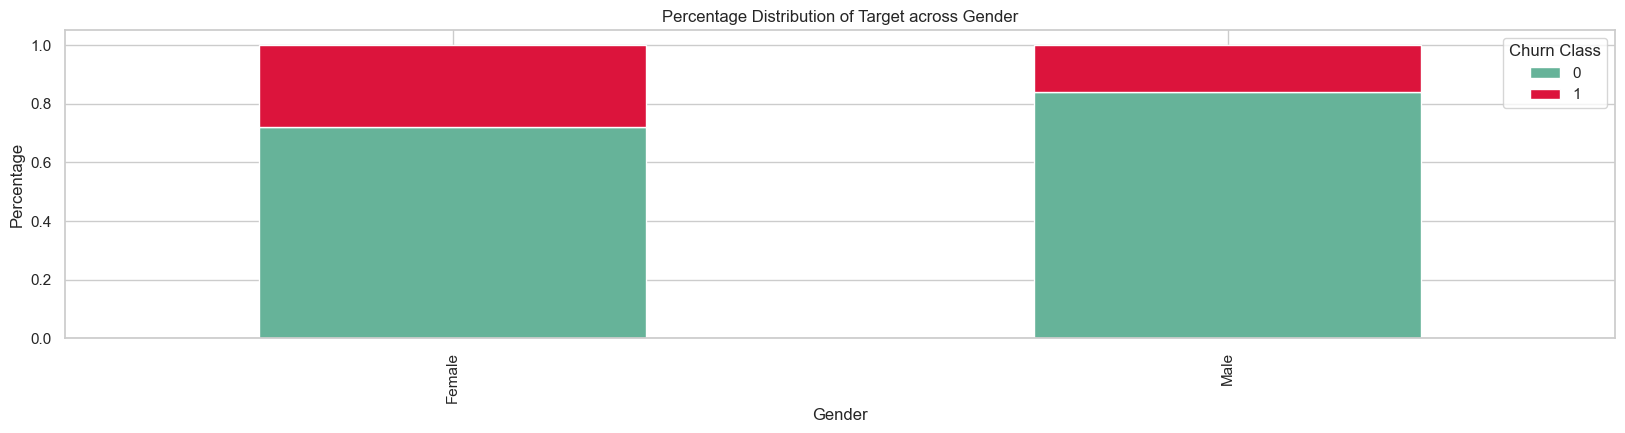

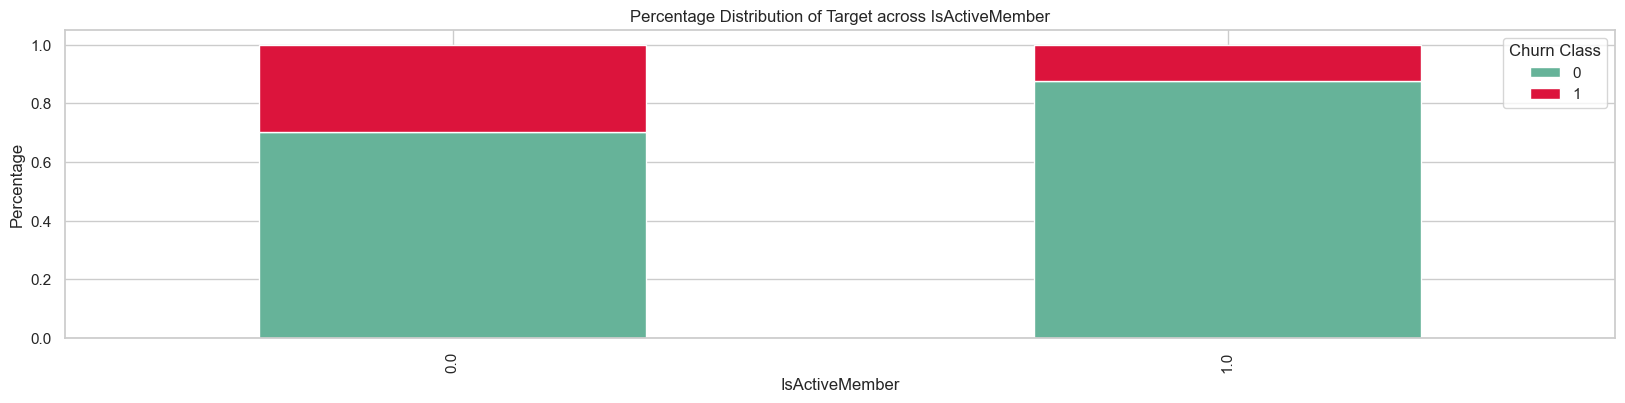

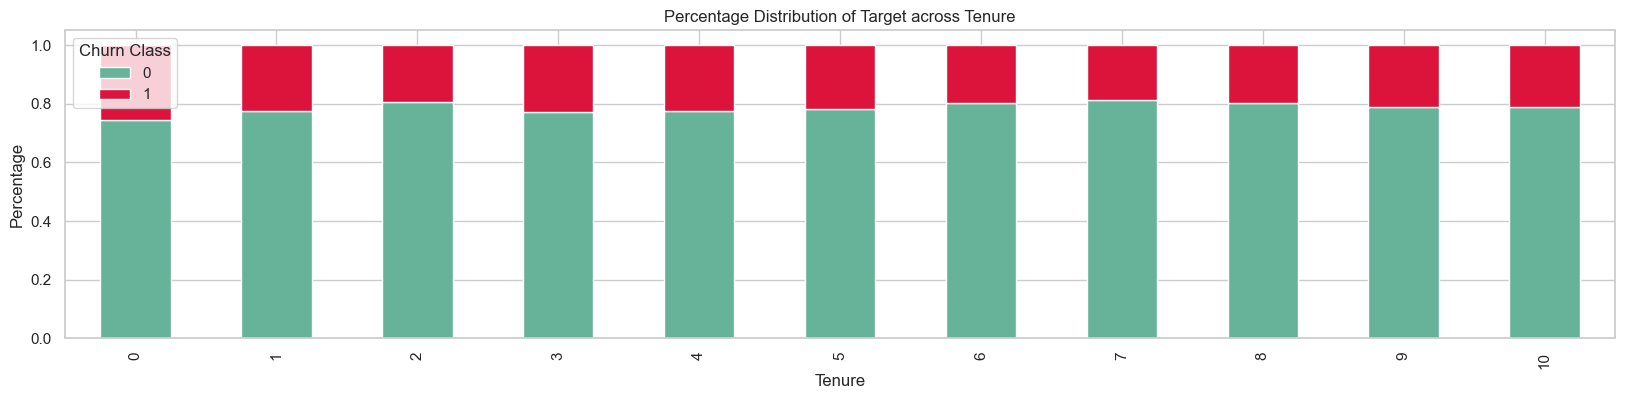

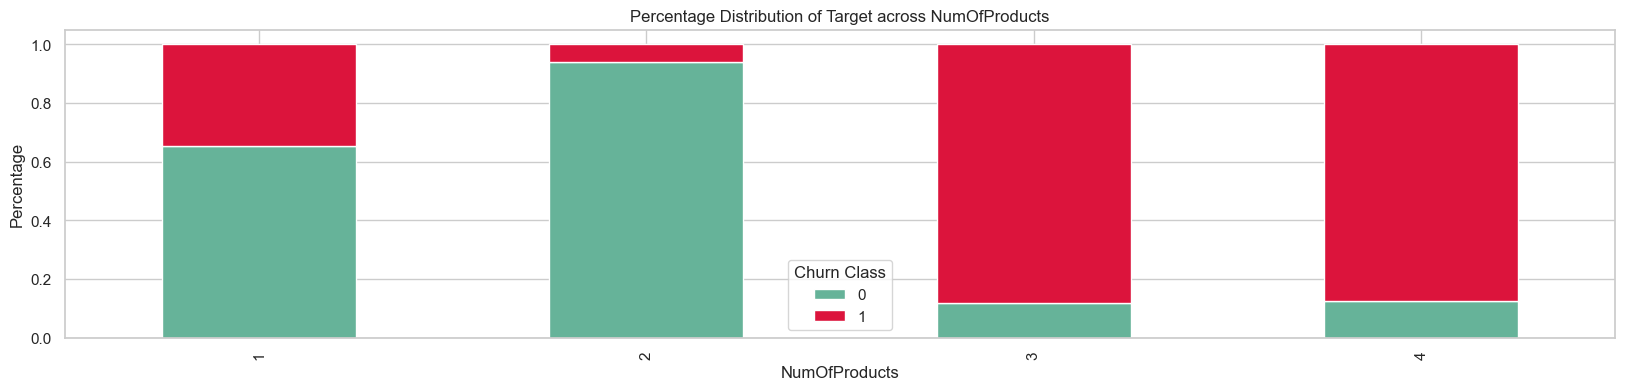

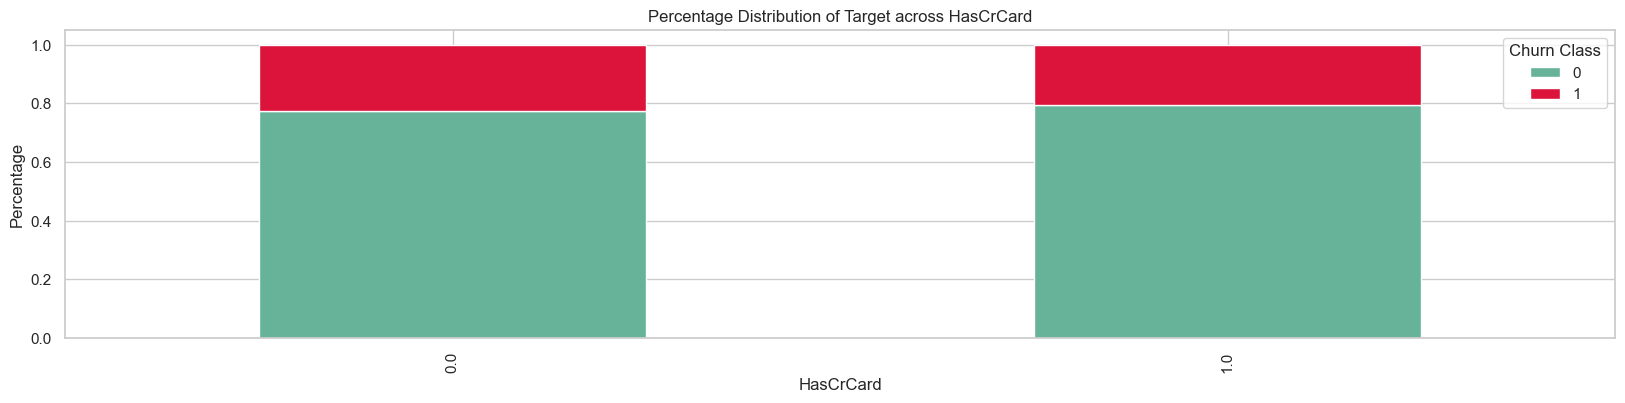

In [336]:
custom_palette =(0.4, 0.7, 0.6), 'crimson'
for col in cat_cols:
    contingency_table = pd.crosstab(train_df[col], train_df[target_col], normalize='index')
    sns.set(style="whitegrid")
    contingency_table.plot(kind="bar", stacked=True, color=custom_palette,figsize=(20, 4))
    plt.title(f"Percentage Distribution of Target across {col}")
    plt.xlabel(col)
    plt.ylabel("Percentage")
    plt.legend(title="Churn Class")
    plt.show()

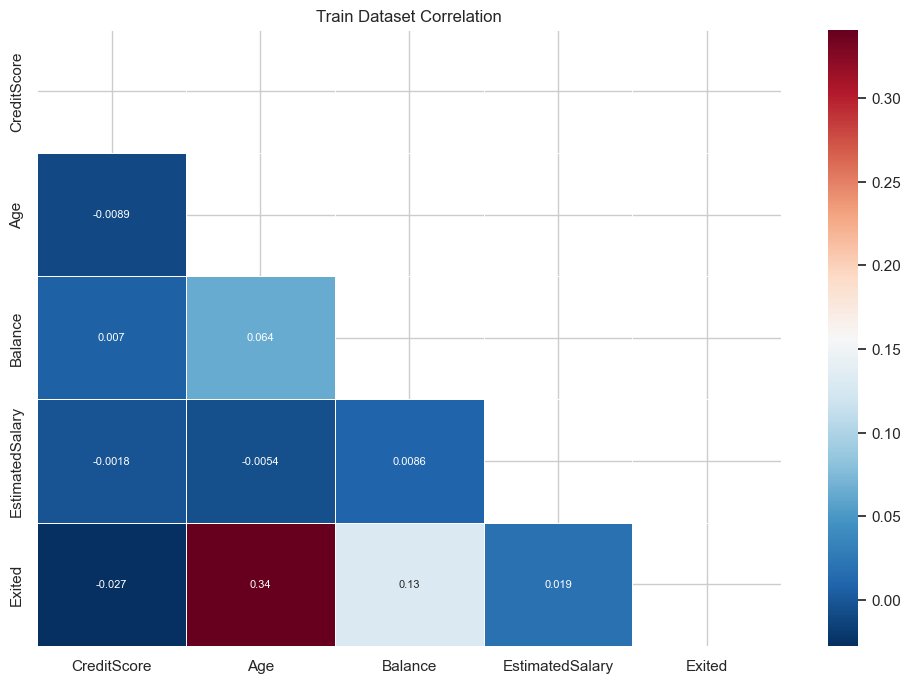

In [337]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:

    corr = df.corr()
    fig, axes = plt.subplots(figsize=(12, 8))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='RdBu_r', annot=True,annot_kws={"size": 8})
    plt.title(title_name)
    plt.show()


plot_correlation_heatmap(train_df[num_cols+[target_col]], 'Train Dataset Correlation')

## 5. Feature Engineering
### 5.1 Arithmetical Operations betweeen columns

In [344]:
class ArithmeticFeatureCombiner(BaseEstimator, TransformerMixin):
    def __init__(self, num_cols):
        self.num_cols = num_cols
        self.new_num_cols = []

    def fit(self, X, y=None):
        # No fitting necessary for this transformer
        return self

    def transform(self, X):
        # Perform the arithmetic operations without creating redundant features
        for i, col1 in enumerate(self.num_cols):
            for col2 in self.num_cols[i+1:]:  # Start from i+1 to avoid redundancy
                X[f'{col1}+{col2}'] = X[col1] + X[col2]
                X[f'{col1}*{col2}'] = X[col1] * X[col2]
                self.new_num_cols.extend([f'{col1}+{col2}', f'{col1}*{col2}'])
        return X

    def get_feature_names_out(self):
        # Return the new column names after transformation
        return self.num_cols + self.new_num_cols

arithmetic_combiner = ArithmeticFeatureCombiner(num_cols)

### 5.2 Binning

In [323]:
class Binning(BaseEstimator, TransformerMixin):
    def __init__(self, col, n_bins):
        self.n_bins = n_bins
        self.col = col
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        transformed = pd.qcut(X[self.col], self.n_bins, labels=False)
        transformed[transformed.isna()] = 0
        transformed_series = pd.Series(transformed, 
                                       name=f'QCut{self.n_bins}{self.col}',
                                       index=X.index)
        X_copy = X.copy()
        return pd.concat([X_copy, transformed_series], axis=1)
    
age_binner = Binning('Age', 5)
balance_binner = Binning('Balance',5)
salary_binner = Binning('Salary',5)
credit_score_binner = Binning('CreditScore',5)

### 5.3 Aggregations

In [555]:
class GroupByMergeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col, agg_col, agg_func):
        self.group_col = group_col
        self.agg_col = agg_col
        self.agg_func = agg_func

    def fit(self, X, y=None):
        # Create the aggregated DataFrame
        self.agg_df_ = X.groupby(by=self.group_col).agg({self.agg_col: self.agg_func}).reset_index().rename(columns={self.agg_col: f'{self.agg_col}_agg'})
        return self

    def transform(self, X):
        # Merge the original DataFrame with the aggregated DataFrame
        return pd.merge(X, self.agg_df_, on=self.group_col, how='left')
    
agg_balance_sum = GroupByMergeTransformer(group_col='CustomerId', agg_col='Balance', agg_func='sum')

### 5.4 Transformations

In [500]:
class ZeroTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        self.new_column_name = column+'_is_zero'

    def fit(self, X, y=None):
        # No fitting necessary for this transformer
        return self

    def transform(self, X):
        # Create a new column with the transformed values
        X[self.new_column_name] = X[self.column].apply(lambda x: 1 if x == 0 else 0)
        return X
    
# Create an instance of your custom transformer
balance_zero_transformer = ZeroTransformer(column='Balance')

### 5.5 Clustering

In [ ]:
class PCAClusteringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, n_components, n_clusters):
        self.columns = columns
        self.n_components = n_components
        self.n_clusters = n_clusters
        self.pca = PCA(n_components=self.n_components)
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)

    def fit(self, X, y=None):
        X_subset = X[self.columns]
        self.pca.fit(X_subset)
        X_pca = self.pca.transform(X_subset)
        self.kmeans.fit(X_pca)
        return self

    def transform(self, X):
        X_subset = X[self.columns]
        X_pca = self.pca.transform(X_subset)
        clusters = self.kmeans.predict(X_pca)
        X_transformed = X.copy()
        X_transformed['Cluster'] = clusters
        for i in range(self.n_components):
            X_transformed[f'PCA_{i}'] = X_pca[:, i]
        return X_transformed
    
pca_clustering_transformer = PCAClusteringTransformer(
    columns=["CustomerId","EstimatedSalary","Balance"], n_components=2, n_clusters=3)

pipeline = Pipeline([
    ('scaler', MinMaxScaler().set_output(transform='pandas')),
    ('pca_clustering', pca_clustering_transformer),
    # ... other steps (e.g., preprocessing, classifiers, etc.)
])

pca_clustering_transformer.fit_transform(train_df)

### 5.6 Encoding

In [312]:
encoding = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore',sparse_output=False), cat_cols)
], remainder='passthrough').set_output(transform='pandas')

### 5.7 Scaling

In [321]:
scaler = MinMaxScaler().set_output(transform='pandas')

## 6. Feature Selection

In [501]:
feature_selector = SelectKBest(chi2, k = 15).set_output(transform='pandas')

In [ ]:
class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, cols=[]):
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        
        return X.drop(self.cols, axis=1)
    
column_drop = DropColumn('CustomerId')

### 6.1 Correlation table 
https://www.kaggle.com/code/ashishkumarak/binary-classification-smoker-or-not-eda-xgboost

In [315]:
correlation_matrix = train_df[num_cols+[target_col]].corr()

table = PrettyTable()
table.field_names = ["Column 1", "Column 2", "Correlation"]

for col1 in num_cols:
    correlation = correlation_matrix.at[col1, target_col]
    table.add_row([col1, target_col, f"{correlation:.2f}"])
table.sortby = "Correlation"

print(table)

+-----------------------------+----------+-------------+
|           Column 1          | Column 2 | Correlation |
+-----------------------------+----------+-------------+
|         CreditScore         |  Exited  |    -0.03    |
|       Age+CreditScore       |  Exited  |     0.01    |
| CreditScore*EstimatedSalary |  Exited  |     0.01    |
|       CreditScore+Age       |  Exited  |     0.01    |
| EstimatedSalary*CreditScore |  Exited  |     0.01    |
|     Age+EstimatedSalary     |  Exited  |     0.02    |
| CreditScore+EstimatedSalary |  Exited  |     0.02    |
|       EstimatedSalary       |  Exited  |     0.02    |
|     EstimatedSalary+Age     |  Exited  |     0.02    |
| EstimatedSalary+CreditScore |  Exited  |     0.02    |
|   Balance+EstimatedSalary   |  Exited  |     0.11    |
|   EstimatedSalary+Balance   |  Exited  |     0.11    |
|   Balance*EstimatedSalary   |  Exited  |     0.12    |
|   EstimatedSalary*Balance   |  Exited  |     0.12    |
|         Age+Balance         |

## 7. Model setup with pre-defined params

In [607]:
best_params_cat = {'learning_rate': 0.01505677476702907, 
               'depth': 10, 
               'subsample': 0.2716781821240621, 
               'random_strength': 4.83060093374094e-05, 
               'l2_leaf_reg': 0.00020833337972882073, 
               'model_size_reg': 4.043233260462883}

best_params_xgb = {'learning_rate': 0.0995227238765534, 
                   'max_depth': 6, 
                   'subsample': 0.8974781754027489, 
                   'colsample_bytree': 0.41327513349222667, 
                   'min_child_weight': 11}

best_params_lgbm = {'learning_rate': 0.0998967279943594, 
                    'max_depth': 7, 
                    'subsample': 0.5231345460679563, 
                    'colsample_bytree': 0.7963988397680257, 
                    'min_child_weight': 9}

best_params_hist = {'learning_rate': 0.02914386061886033, 
                    'max_iter': 998, 
                    'max_leaf_nodes': 48, 
                    'min_samples_leaf': 25, 
                    'l2_regularization': 2.45430963795829e-09}

catboost_model = CatBoostClassifier(**best_params_cat, silent=True)
xgboost_model = XGBClassifier(**best_params_xgb)
lgbm_model = LGBMClassifier(**best_params_lgbm)
hist_model = HistGradientBoostingClassifier(**best_params_hist)

## 8. Pipeline setup

In [556]:
pipeline_baseline = Pipeline([
    ('encoder', encoding),
    ])

pipeline_baseline_binning = Pipeline([
    ('age_binning', age_binner),
    ('encoder', encoding),
    ])

pipeline_baseline_binning_sel = Pipeline([
    ('age_binning', age_binner),
    ('encoder', encoding),
    ('skb', feature_selector)
    ])

pipeline_baseline_binning_sel_arth = Pipeline([
    ('arithmetic_combiner', arithmetic_combiner),
    ('age_binning', age_binner),
    ('encoder', encoding),
    ('skb', feature_selector)
    ])

pipeline_baseline_plus = Pipeline([
    ('balance_zero_transformer', balance_zero_transformer),
    ('age_binning', age_binner),
    ('encoder', encoding),
    ])

pipeline_baseline_plus_sel = Pipeline([
    ('agg_balance_sum', agg_balance_sum),
    ('balance_zero_transformer', balance_zero_transformer),
    ('age_binning', age_binner),
    ('encoder', encoding),
    ('skb', feature_selector)
    ])

pipeline_baseline_plus_sel_pca = Pipeline([
    ('agg_balance_sum', agg_balance_sum),
    ('balance_zero_transformer', balance_zero_transformer),
    ('age_binning', age_binner),
    ('encoder', encoding),
    ('scaler', scaler),
    ('pca_cluster', pca_clustering_transformer),
    ('skb', feature_selector)
    ])

pipeline_all = Pipeline([
    ('arithmetic_combiner', arithmetic_combiner),
    ('agg_balance_sum', agg_balance_sum),
    ('balance_zero_transformer', balance_zero_transformer),
    ('age_binning', age_binner),
    ('encoder', encoding),
    ('scaler', scaler),
    ('pca_cluster', pca_clustering_transformer),
    ('skb', feature_selector)
    ])


selected_pipeline = pipeline_baseline_plus_sel
selected_pipeline

Pipeline(steps=[('agg_balance_sum',
                 GroupByMergeTransformer(agg_col='Balance', agg_func='sum',
                                         group_col='CustomerId')),
                ('balance_zero_transformer', ZeroTransformer(column='Balance')),
                ('age_binning', AgeBinning(n_bins=5)),
                ('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Geography', 'Gender',
                                                   'IsActiveMember', 'Tenure',
                                                   'NumOfProducts',
                                                   'HasCrCard'])])),
                ('skb',
                 SelectKBest(k=15, score_func=<function chi2 at 0x15cbcbc40>))])

In [608]:
catboost_pipeline = make_pipeline(selected_pipeline, catboost_model)

xgboost_pipeline = make_pipeline(selected_pipeline, xgboost_model)

lgbm_pipeline = make_pipeline(selected_pipeline, lgbm_model)

hist_pipeline = make_pipeline(selected_pipeline, hist_model)

In [437]:
def log_results(pipeline, params, cv, model):
    steps = [step[0] for step in pipeline.named_steps['pipeline'].steps]
    steps = ', '.join(steps)
    log_df = pd.DataFrame()
    log_df['Time'] = [datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')]
    log_df['Pipeline'] = [steps]
    log_df['Params'] = [params]
    log_df['ROC AUC'] = [cv]
    log_df['Model'] = [model]

    if os.path.exists('log.csv'):
        log_df_ = pd.read_csv('log.csv')
        log_df = pd.concat([log_df_, log_df])
        log_df.to_csv('log.csv', index=False)
    else:
        log_df.to_csv('log.csv', index=False)

## 9. Training

### Optuna

In [602]:
def instantiate_catboost(trial : Trial) -> CatBoostClassifier:
  params = {
        "iterations": 100,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        'random_strength': trial.suggest_float('random_strength',1e-6,10,log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg',1e-8,100,log=True),
        'model_size_reg': trial.suggest_float('model_size_reg',1e-8,100,log=True),
    }
  return CatBoostClassifier(**params, silent=True)

def instantiate_xgboost(trial : Trial) -> XGBClassifier:
  params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
  }
  return XGBClassifier(**params)

def instantiate_lgbm(trial : Trial) -> LGBMClassifier:
  params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
  }
  return LGBMClassifier(**params)

def instantiate_hist(trial: Trial) -> HistGradientBoostingClassifier:
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 20, 64),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 20, 60),
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-10, 1.0, log=True)
    }
    return HistGradientBoostingClassifier(**params)

In [603]:
def objective(trial : Trial, pipeline, algo):
    X = train_df[cat_cols+num_cols+['CustomerId']]
    y = train_df['Exited']

    if algo == 'cat':
        # CATBOOST
        pipeline = make_pipeline(pipeline, instantiate_catboost(trial))
    elif algo == 'xgb':
        # XGBOOST
        pipeline = make_pipeline(pipeline, instantiate_xgboost(trial))
    elif algo == 'lgbm':
        # LGBM
        pipeline = make_pipeline(pipeline, instantiate_lgbm(trial))
    elif algo == 'hist':
        pipeline = make_pipeline(pipeline, instantiate_hist(trial))

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    scores = cross_val_score(pipeline, X, y, scoring=roc_auc_scorer, cv=skf)
  
    return np.min([np.mean(scores), np.median([scores])])

In [562]:
study = create_study(study_name='optimization', direction='maximize', pruner=optuna.pruners.MedianPruner())

study.optimize(lambda trial: objective(trial, selected_pipeline), n_trials=50)

[I 2024-01-18 20:12:25,976] A new study created in memory with name: optimization
[I 2024-01-18 20:12:32,107] Trial 0 finished with value: 0.8866345788738279 and parameters: {'learning_rate': 0.0640292715063446, 'depth': 7, 'subsample': 0.08168640160070685, 'random_strength': 6.915262738736656e-06, 'l2_leaf_reg': 8.789984245833185, 'model_size_reg': 1.0108037877678784}. Best is trial 0 with value: 0.8866345788738279.
[I 2024-01-18 20:12:36,725] Trial 1 finished with value: 0.8838884978241062 and parameters: {'learning_rate': 0.022900173332229126, 'depth': 5, 'subsample': 0.14737748484993246, 'random_strength': 0.5846534244541821, 'l2_leaf_reg': 0.0003383587138462115, 'model_size_reg': 0.00022566173527363627}. Best is trial 0 with value: 0.8866345788738279.
[I 2024-01-18 20:12:51,199] Trial 2 finished with value: 0.8845692681195791 and parameters: {'learning_rate': 0.002149803009607883, 'depth': 10, 'subsample': 0.06562796557070492, 'random_strength': 0.886536808854381, 'l2_leaf_reg': 0

In [568]:
study1 = create_study(study_name='optimization', direction='maximize', pruner=optuna.pruners.MedianPruner())

study1.optimize(lambda trial: objective(trial, selected_pipeline, 'xgb'), n_trials=50)

[I 2024-01-18 20:30:08,546] A new study created in memory with name: optimization
[I 2024-01-18 20:30:15,461] Trial 0 finished with value: 0.8871009668457775 and parameters: {'learning_rate': 0.04517440998912212, 'max_depth': 9, 'subsample': 0.7999733666430413, 'colsample_bytree': 0.7124971916100009, 'min_child_weight': 5}. Best is trial 0 with value: 0.8871009668457775.
[I 2024-01-18 20:30:22,168] Trial 1 finished with value: 0.8858596046098275 and parameters: {'learning_rate': 0.0054483651690426455, 'max_depth': 9, 'subsample': 0.7609990796586651, 'colsample_bytree': 0.9476358536424576, 'min_child_weight': 19}. Best is trial 0 with value: 0.8871009668457775.
[I 2024-01-18 20:30:25,961] Trial 2 finished with value: 0.8739623298731651 and parameters: {'learning_rate': 0.012687186717719196, 'max_depth': 3, 'subsample': 0.8398316373102301, 'colsample_bytree': 0.6672220356974892, 'min_child_weight': 20}. Best is trial 0 with value: 0.8871009668457775.
[I 2024-01-18 20:30:30,157] Trial 3 f

In [569]:
study2 = create_study(study_name='optimization', direction='maximize', pruner=optuna.pruners.MedianPruner())

study2.optimize(lambda trial: objective(trial, selected_pipeline, 'lgbm'), n_trials=50)

[I 2024-01-18 20:40:35,664] A new study created in memory with name: optimization


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:40:43,392] Trial 0 finished with value: 0.887474586003919 and parameters: {'learning_rate': 0.06583214147746945, 'max_depth': 8, 'subsample': 0.2265368491029887, 'colsample_bytree': 0.5677145103125882, 'min_child_weight': 16}. Best is trial 0 with value: 0.887474586003919.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.

[I 2024-01-18 20:40:46,955] Trial 1 finished with value: 0.8657032045661239 and parameters: {'learning_rate': 0.007501683499919533, 'max_depth': 2, 'subsample': 0.33050503838879847, 'colsample_bytree': 0.11589954736887258, 'min_child_weight': 14}. Best is trial 0 with value: 0.887474586003919.


[LightGBM] [Info] Number of positive: 31429, number of negative: 117102
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148531, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211599 -> initscore=-1.315314
[LightGBM] [Info] Start training from score -1.315314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of po

[I 2024-01-18 20:40:54,904] Trial 2 finished with value: 0.883541532352174 and parameters: {'learning_rate': 0.009782671520752446, 'max_depth': 8, 'subsample': 0.9751861596552789, 'colsample_bytree': 0.37334631749486497, 'min_child_weight': 6}. Best is trial 0 with value: 0.887474586003919.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:41:02,640] Trial 3 finished with value: 0.8841190461538272 and parameters: {'learning_rate': 0.007339257744205445, 'max_depth': 10, 'subsample': 0.809473600598107, 'colsample_bytree': 0.6693884120664638, 'min_child_weight': 8}. Best is trial 0 with value: 0.887474586003919.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [I

[I 2024-01-18 20:41:08,083] Trial 4 finished with value: 0.8789526757824004 and parameters: {'learning_rate': 0.0018567127934036567, 'max_depth': 4, 'subsample': 0.06665254006536923, 'colsample_bytree': 0.405860213063715, 'min_child_weight': 6}. Best is trial 0 with value: 0.887474586003919.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-01-18 20:41:11,979] Trial 5 finished with value: 0.860445988453812 and parameters: {'learning_rate': 0.05263651613995823, 'max_depth': 4, 'subsample': 0.8586319600751107, 'colsample_bytree': 0.09440178242085766, 'min_child_weight': 1}. Best is trial 0 with value: 0.887474586003919.


[LightGBM] [Info] Number of positive: 31429, number of negative: 117102
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148531, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211599 -> initscore=-1.315314
[LightGBM] [Info] Start training from score -1.315314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-01-18 20:41:15,512] Trial 6 finished with value: 0.8625776891984316 and parameters: {'learning_rate': 0.010614981645045474, 'max_depth': 2, 'subsample': 0.4204450099886841, 'colsample_bytree': 0.671724419310123, 'min_child_weight': 20}. Best is trial 0 with value: 0.887474586003919.


[LightGBM] [Info] Number of positive: 31429, number of negative: 117102
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148531, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211599 -> initscore=-1.315314
[LightGBM] [Info] Start training from score -1.315314
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You 

[I 2024-01-18 20:41:22,736] Trial 7 finished with value: 0.883411020043574 and parameters: {'learning_rate': 0.003807851027060417, 'max_depth': 6, 'subsample': 0.7630988167613285, 'colsample_bytree': 0.4935849691337091, 'min_child_weight': 8}. Best is trial 0 with value: 0.887474586003919.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:41:30,272] Trial 8 finished with value: 0.8866508055612121 and parameters: {'learning_rate': 0.034977344589329634, 'max_depth': 9, 'subsample': 0.9328523892509223, 'colsample_bytree': 0.6001189991909757, 'min_child_weight': 17}. Best is trial 0 with value: 0.887474586003919.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [

[I 2024-01-18 20:41:34,790] Trial 9 finished with value: 0.8715246976235296 and parameters: {'learning_rate': 0.004097810666664721, 'max_depth': 3, 'subsample': 0.9131425001721818, 'colsample_bytree': 0.5603438517502332, 'min_child_weight': 16}. Best is trial 0 with value: 0.887474586003919.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:41:42,360] Trial 10 finished with value: 0.8876548546186269 and parameters: {'learning_rate': 0.09884489851538067, 'max_depth': 7, 'subsample': 0.07694101033510714, 'colsample_bytree': 0.9658066021806486, 'min_child_weight': 12}. Best is trial 10 with value: 0.8876548546186269.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start train

[I 2024-01-18 20:41:49,877] Trial 11 finished with value: 0.8876722800843448 and parameters: {'learning_rate': 0.09593117364042116, 'max_depth': 7, 'subsample': 0.12605156233362413, 'colsample_bytree': 0.9966919303809116, 'min_child_weight': 12}. Best is trial 11 with value: 0.8876722800843448.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start train

[I 2024-01-18 20:41:57,664] Trial 12 finished with value: 0.8875979878907985 and parameters: {'learning_rate': 0.09617439797966353, 'max_depth': 6, 'subsample': 0.09811476369217953, 'colsample_bytree': 0.970547014762772, 'min_child_weight': 12}. Best is trial 11 with value: 0.8876722800843448.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:42:05,933] Trial 13 finished with value: 0.885880110068328 and parameters: {'learning_rate': 0.023792921113806948, 'max_depth': 7, 'subsample': 0.6184472786674883, 'colsample_bytree': 0.9972489657610252, 'min_child_weight': 11}. Best is trial 11 with value: 0.8876722800843448.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:42:12,850] Trial 14 finished with value: 0.8849520918265474 and parameters: {'learning_rate': 0.021995889124918074, 'max_depth': 5, 'subsample': 0.21321888573653988, 'colsample_bytree': 0.8525603011302473, 'min_child_weight': 12}. Best is trial 11 with value: 0.8876722800843448.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positi

[I 2024-01-18 20:42:20,454] Trial 15 finished with value: 0.887927758797741 and parameters: {'learning_rate': 0.0998967279943594, 'max_depth': 7, 'subsample': 0.5231345460679563, 'colsample_bytree': 0.7963988397680257, 'min_child_weight': 9}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:42:28,048] Trial 16 finished with value: 0.8868928833510239 and parameters: {'learning_rate': 0.04098622684754784, 'max_depth': 8, 'subsample': 0.5709937216574551, 'colsample_bytree': 0.8141890119371811, 'min_child_weight': 2}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:42:36,796] Trial 17 finished with value: 0.8851148167164572 and parameters: {'learning_rate': 0.018144485045733075, 'max_depth': 10, 'subsample': 0.4504151770683743, 'colsample_bytree': 0.8432412843001219, 'min_child_weight': 9}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:42:45,819] Trial 18 finished with value: 0.8875489966786597 and parameters: {'learning_rate': 0.0649572863837167, 'max_depth': 7, 'subsample': 0.7040144699818839, 'colsample_bytree': 0.7498518366327611, 'min_child_weight': 4}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positi

[I 2024-01-18 20:42:53,378] Trial 19 finished with value: 0.8745372395267271 and parameters: {'learning_rate': 0.001292874079755396, 'max_depth': 5, 'subsample': 0.3415597866617134, 'colsample_bytree': 0.8873376657663161, 'min_child_weight': 14}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:43:02,559] Trial 20 finished with value: 0.8863700381992399 and parameters: {'learning_rate': 0.029458481686709143, 'max_depth': 9, 'subsample': 0.6755825769686474, 'colsample_bytree': 0.7533016322696637, 'min_child_weight': 10}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positi

[I 2024-01-18 20:43:09,886] Trial 21 finished with value: 0.8875220763565981 and parameters: {'learning_rate': 0.09972025801064743, 'max_depth': 7, 'subsample': 0.17247673653096857, 'colsample_bytree': 0.9373744396766709, 'min_child_weight': 13}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positi

[I 2024-01-18 20:43:16,946] Trial 22 finished with value: 0.8874768040989038 and parameters: {'learning_rate': 0.09965076865842827, 'max_depth': 6, 'subsample': 0.3054986250202322, 'colsample_bytree': 0.9179271622440663, 'min_child_weight': 6}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train 

[I 2024-01-18 20:43:25,031] Trial 23 finished with value: 0.8872352198759785 and parameters: {'learning_rate': 0.05339148133350922, 'max_depth': 7, 'subsample': 0.14033337174679195, 'colsample_bytree': 0.7709049383322532, 'min_child_weight': 10}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:43:34,304] Trial 24 finished with value: 0.8874778121696631 and parameters: {'learning_rate': 0.06567414993472484, 'max_depth': 9, 'subsample': 0.05159937274589571, 'colsample_bytree': 0.9787762491358539, 'min_child_weight': 8}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positi

[I 2024-01-18 20:43:41,875] Trial 25 finished with value: 0.886975141221152 and parameters: {'learning_rate': 0.044983089136244825, 'max_depth': 5, 'subsample': 0.4921615788280834, 'colsample_bytree': 0.6871731010448221, 'min_child_weight': 14}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad sinc

[I 2024-01-18 20:43:49,657] Trial 26 finished with value: 0.887371913400131 and parameters: {'learning_rate': 0.07397874556575508, 'max_depth': 8, 'subsample': 0.18486505570925776, 'colsample_bytree': 0.871061832871421, 'min_child_weight': 11}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positi

[I 2024-01-18 20:43:57,080] Trial 27 finished with value: 0.8802115783956883 and parameters: {'learning_rate': 0.03200773744774122, 'max_depth': 6, 'subsample': 0.2702665757049142, 'colsample_bytree': 0.26760022532217004, 'min_child_weight': 18}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFro

[I 2024-01-18 20:44:04,775] Trial 28 finished with value: 0.8847174527096335 and parameters: {'learning_rate': 0.01567856903119456, 'max_depth': 7, 'subsample': 0.39527316333194573, 'colsample_bytree': 0.9278137319146267, 'min_child_weight': 13}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:44:12,376] Trial 29 finished with value: 0.8874854843708488 and parameters: {'learning_rate': 0.07081035240116926, 'max_depth': 8, 'subsample': 0.25107711195700233, 'colsample_bytree': 0.8042547624817022, 'min_child_weight': 16}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positi

[I 2024-01-18 20:44:19,457] Trial 30 finished with value: 0.8874368173551281 and parameters: {'learning_rate': 0.07815561088217947, 'max_depth': 6, 'subsample': 0.12483723146483278, 'colsample_bytree': 0.9995050836493553, 'min_child_weight': 9}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start train

[I 2024-01-18 20:44:26,347] Trial 31 finished with value: 0.8875476379830856 and parameters: {'learning_rate': 0.09631471414753959, 'max_depth': 6, 'subsample': 0.10323854764769744, 'colsample_bytree': 0.9448662971119046, 'min_child_weight': 12}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explici

[I 2024-01-18 20:44:33,803] Trial 32 finished with value: 0.8872295005122914 and parameters: {'learning_rate': 0.05300299246713188, 'max_depth': 7, 'subsample': 0.0505947500051207, 'colsample_bytree': 0.8953420038025537, 'min_child_weight': 15}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positi

[I 2024-01-18 20:44:40,163] Trial 33 finished with value: 0.8874642880201551 and parameters: {'learning_rate': 0.0846716251906807, 'max_depth': 5, 'subsample': 0.20386793084155574, 'colsample_bytree': 0.994368726892506, 'min_child_weight': 12}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_

[I 2024-01-18 20:44:47,277] Trial 34 finished with value: 0.887261290214051 and parameters: {'learning_rate': 0.058010641987904885, 'max_depth': 6, 'subsample': 0.1389307714497885, 'colsample_bytree': 0.9342870750448363, 'min_child_weight': 7}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positi

[I 2024-01-18 20:44:53,970] Trial 35 finished with value: 0.8799604057623842 and parameters: {'learning_rate': 0.04070938876408981, 'max_depth': 8, 'subsample': 0.3619801628160205, 'colsample_bytree': 0.1802033925069249, 'min_child_weight': 10}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start train

[I 2024-01-18 20:45:01,498] Trial 36 finished with value: 0.8876351055774785 and parameters: {'learning_rate': 0.07778865414384063, 'max_depth': 8, 'subsample': 0.27980364204598923, 'colsample_bytree': 0.8185804284957474, 'min_child_weight': 13}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:45:09,950] Trial 37 finished with value: 0.8870609013461046 and parameters: {'learning_rate': 0.0463872079192345, 'max_depth': 9, 'subsample': 0.2665949498655876, 'colsample_bytree': 0.7444954237739524, 'min_child_weight': 15}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:45:18,252] Trial 38 finished with value: 0.8830405189352952 and parameters: {'learning_rate': 0.0053158104908614945, 'max_depth': 8, 'subsample': 0.5007730774466304, 'colsample_bytree': 0.8111340248995389, 'min_child_weight': 4}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:45:26,829] Trial 39 finished with value: 0.8833922512301909 and parameters: {'learning_rate': 0.0025881032503053307, 'max_depth': 10, 'subsample': 0.307714491829979, 'colsample_bytree': 0.6295844110406817, 'min_child_weight': 18}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positi

[I 2024-01-18 20:45:36,107] Trial 40 finished with value: 0.8874208836311757 and parameters: {'learning_rate': 0.07744189719529329, 'max_depth': 7, 'subsample': 0.5815931837640538, 'colsample_bytree': 0.4948366179496946, 'min_child_weight': 13}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:45:44,592] Trial 41 finished with value: 0.8876035041699715 and parameters: {'learning_rate': 0.08264890308546695, 'max_depth': 8, 'subsample': 0.0952489300038446, 'colsample_bytree': 0.6980295128925285, 'min_child_weight': 11}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:45:53,074] Trial 42 finished with value: 0.8875666463958681 and parameters: {'learning_rate': 0.06355877221112313, 'max_depth': 9, 'subsample': 0.1657634732226466, 'colsample_bytree': 0.7046653943031836, 'min_child_weight': 9}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:46:01,402] Trial 43 finished with value: 0.887640631048384 and parameters: {'learning_rate': 0.08193438728419075, 'max_depth': 8, 'subsample': 0.09209132681137636, 'colsample_bytree': 0.6335921734755526, 'min_child_weight': 11}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positi

[I 2024-01-18 20:46:09,868] Trial 44 finished with value: 0.8871279487815887 and parameters: {'learning_rate': 0.060489398018841005, 'max_depth': 8, 'subsample': 0.22573574965010237, 'colsample_bytree': 0.4268541658861821, 'min_child_weight': 14}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:46:18,480] Trial 45 finished with value: 0.8867962672324765 and parameters: {'learning_rate': 0.03768921095869212, 'max_depth': 7, 'subsample': 0.08477907799311696, 'colsample_bytree': 0.6055708274632126, 'min_child_weight': 7}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:46:26,788] Trial 46 finished with value: 0.8838227399091244 and parameters: {'learning_rate': 0.011192225342396474, 'max_depth': 9, 'subsample': 0.17545707869093577, 'colsample_bytree': 0.8481729095751834, 'min_child_weight': 11}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:46:35,312] Trial 47 finished with value: 0.8860868717746364 and parameters: {'learning_rate': 0.02772511508530974, 'max_depth': 8, 'subsample': 0.13834813279663633, 'colsample_bytree': 0.5497378366690598, 'min_child_weight': 13}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:46:43,626] Trial 48 finished with value: 0.8872782811305779 and parameters: {'learning_rate': 0.049284092023097706, 'max_depth': 7, 'subsample': 0.787566912191322, 'colsample_bytree': 0.6501374239874065, 'min_child_weight': 9}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:46:51,795] Trial 49 finished with value: 0.8877010384015973 and parameters: {'learning_rate': 0.08422606869677023, 'max_depth': 8, 'subsample': 0.42726057533382866, 'colsample_bytree': 0.787470650062883, 'min_child_weight': 15}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2024-01-18 20:46:57,311] Trial 50 finished with value: 0.8872764363853318 and parameters: {'learning_rate': 0.08553249880796601, 'max_depth': 4, 'subsample': 0.45407819779190944, 'colsample_bytree': 0.8864179786100166, 'min_child_weight': 15}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-18 20:47:04,951] Trial 51 finished with value: 0.8876523360209423 and parameters: {'learning_rate': 0.07360639738718744, 'max_depth': 8, 'subsample': 0.5634021332308559, 'colsample_bytree': 0.8036815641508096, 'min_child_weight': 12}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:47:12,780] Trial 52 finished with value: 0.8875399935933885 and parameters: {'learning_rate': 0.06523272259787609, 'max_depth': 7, 'subsample': 0.6479130438635892, 'colsample_bytree': 0.7372820069109463, 'min_child_weight': 20}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:47:21,068] Trial 53 finished with value: 0.8877529250976528 and parameters: {'learning_rate': 0.09733473247536038, 'max_depth': 8, 'subsample': 0.559268326809014, 'colsample_bytree': 0.8005688552094827, 'min_child_weight': 12}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:47:29,403] Trial 54 finished with value: 0.8875801451456347 and parameters: {'learning_rate': 0.09927266684503232, 'max_depth': 9, 'subsample': 0.5643170020656573, 'colsample_bytree': 0.9585547248245315, 'min_child_weight': 12}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:47:37,803] Trial 55 finished with value: 0.8872128055600956 and parameters: {'learning_rate': 0.05477677014798366, 'max_depth': 7, 'subsample': 0.7271467803994959, 'colsample_bytree': 0.7900335460155743, 'min_child_weight': 14}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [

[I 2024-01-18 20:47:41,985] Trial 56 finished with value: 0.8830460417156302 and parameters: {'learning_rate': 0.06947603782186959, 'max_depth': 2, 'subsample': 0.539559584610108, 'colsample_bytree': 0.8396444552629152, 'min_child_weight': 17}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Info] Number of positive: 31429, number of negative: 117102
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148531, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211599 -> initscore=-1.315314
[LightGBM] [Info] Start training from score -1.315314
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001066 seconds.
You 

[I 2024-01-18 20:47:49,753] Trial 57 finished with value: 0.8876033067674762 and parameters: {'learning_rate': 0.09735481221709691, 'max_depth': 6, 'subsample': 0.6214625392359955, 'colsample_bytree': 0.899427855069249, 'min_child_weight': 8}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start train

[I 2024-01-18 20:47:58,011] Trial 58 finished with value: 0.8839540060516244 and parameters: {'learning_rate': 0.007632945279111368, 'max_depth': 7, 'subsample': 0.45811133989969693, 'colsample_bytree': 0.7081546014950681, 'min_child_weight': 10}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:48:05,825] Trial 59 finished with value: 0.8870355847946741 and parameters: {'learning_rate': 0.04419695891162608, 'max_depth': 10, 'subsample': 0.4085602905928531, 'colsample_bytree': 0.7806398479717473, 'min_child_weight': 12}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:48:13,563] Trial 60 finished with value: 0.8877145077236426 and parameters: {'learning_rate': 0.08785830259607888, 'max_depth': 8, 'subsample': 0.5231600950709918, 'colsample_bytree': 0.8497194753056152, 'min_child_weight': 10}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:48:22,564] Trial 61 finished with value: 0.8877815698769254 and parameters: {'learning_rate': 0.08739593128879594, 'max_depth': 8, 'subsample': 0.5133345555994102, 'colsample_bytree': 0.8774972681980595, 'min_child_weight': 10}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:48:30,098] Trial 62 finished with value: 0.8877789610427358 and parameters: {'learning_rate': 0.08966638481408055, 'max_depth': 7, 'subsample': 0.48829469073442494, 'colsample_bytree': 0.8729105476271897, 'min_child_weight': 9}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:48:39,400] Trial 63 finished with value: 0.8876964978732564 and parameters: {'learning_rate': 0.08672588419447012, 'max_depth': 8, 'subsample': 0.5203909366727695, 'colsample_bytree': 0.8628238494649125, 'min_child_weight': 7}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:48:47,027] Trial 64 finished with value: 0.8876786702790922 and parameters: {'learning_rate': 0.08600762680213288, 'max_depth': 9, 'subsample': 0.5092240977431873, 'colsample_bytree': 0.8489432065519562, 'min_child_weight': 5}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:48:54,651] Trial 65 finished with value: 0.8874127150071291 and parameters: {'learning_rate': 0.05945138883915356, 'max_depth': 8, 'subsample': 0.4738626921296142, 'colsample_bytree': 0.8634176252276065, 'min_child_weight': 7}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:49:02,311] Trial 66 finished with value: 0.8874489525527463 and parameters: {'learning_rate': 0.06927251515902352, 'max_depth': 9, 'subsample': 0.5331599640346933, 'colsample_bytree': 0.9172249878608407, 'min_child_weight': 8}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:49:10,167] Trial 67 finished with value: 0.8873340418165397 and parameters: {'learning_rate': 0.05135919108317393, 'max_depth': 8, 'subsample': 0.3754200782191752, 'colsample_bytree': 0.724381581180664, 'min_child_weight': 9}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:49:18,027] Trial 68 finished with value: 0.8877386570778618 and parameters: {'learning_rate': 0.08661065874587849, 'max_depth': 8, 'subsample': 0.4301230332220787, 'colsample_bytree': 0.7688959013522074, 'min_child_weight': 6}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:49:26,503] Trial 69 finished with value: 0.8865374773640737 and parameters: {'learning_rate': 0.034471311016140364, 'max_depth': 7, 'subsample': 0.4280278365887243, 'colsample_bytree': 0.7815514071121731, 'min_child_weight': 2}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:49:35,213] Trial 70 finished with value: 0.8875858220209917 and parameters: {'learning_rate': 0.06112449990368563, 'max_depth': 9, 'subsample': 0.4269603802184425, 'colsample_bytree': 0.6731441097714006, 'min_child_weight': 5}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:49:43,503] Trial 71 finished with value: 0.8877306328703448 and parameters: {'learning_rate': 0.08731092886068564, 'max_depth': 8, 'subsample': 0.5893484956827665, 'colsample_bytree': 0.7606751728417995, 'min_child_weight': 8}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:49:51,424] Trial 72 finished with value: 0.8876864471998654 and parameters: {'learning_rate': 0.08824749559847768, 'max_depth': 8, 'subsample': 0.608289704999811, 'colsample_bytree': 0.7634101849570835, 'min_child_weight': 10}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:49:59,483] Trial 73 finished with value: 0.8875887201088388 and parameters: {'learning_rate': 0.07211984847858198, 'max_depth': 8, 'subsample': 0.48644462504214553, 'colsample_bytree': 0.8358764919355139, 'min_child_weight': 6}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:50:07,449] Trial 74 finished with value: 0.8878266643616319 and parameters: {'learning_rate': 0.08946658644916194, 'max_depth': 8, 'subsample': 0.6550118617467978, 'colsample_bytree': 0.754366402232365, 'min_child_weight': 8}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:50:16,050] Trial 75 finished with value: 0.8876796469120789 and parameters: {'learning_rate': 0.09854499798543329, 'max_depth': 9, 'subsample': 0.6739394821495426, 'colsample_bytree': 0.8235761988304185, 'min_child_weight': 8}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:50:24,982] Trial 76 finished with value: 0.8874967265432259 and parameters: {'learning_rate': 0.06945498757260471, 'max_depth': 7, 'subsample': 0.5954531568368965, 'colsample_bytree': 0.7240524907598875, 'min_child_weight': 9}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:50:33,939] Trial 77 finished with value: 0.8872361313476953 and parameters: {'learning_rate': 0.05601006343371939, 'max_depth': 8, 'subsample': 0.5515630421802908, 'colsample_bytree': 0.7619597297746733, 'min_child_weight': 7}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:50:43,119] Trial 78 finished with value: 0.8818265822390307 and parameters: {'learning_rate': 0.0017123556344543394, 'max_depth': 7, 'subsample': 0.6592541081932946, 'colsample_bytree': 0.8846115753035131, 'min_child_weight': 8}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positi

[I 2024-01-18 20:50:51,691] Trial 79 finished with value: 0.8865641025913562 and parameters: {'learning_rate': 0.08952082200684208, 'max_depth': 8, 'subsample': 0.6339051524075038, 'colsample_bytree': 0.323000564297086, 'min_child_weight': 10}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:50:59,253] Trial 80 finished with value: 0.8876503191217162 and parameters: {'learning_rate': 0.07595990620921327, 'max_depth': 7, 'subsample': 0.5877160345617232, 'colsample_bytree': 0.9078174693182437, 'min_child_weight': 9}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:51:06,942] Trial 81 finished with value: 0.8877117195963244 and parameters: {'learning_rate': 0.08261172477060129, 'max_depth': 8, 'subsample': 0.6964874559376614, 'colsample_bytree': 0.8037104086139016, 'min_child_weight': 6}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:51:14,471] Trial 82 finished with value: 0.8876538556450835 and parameters: {'learning_rate': 0.07809340829368233, 'max_depth': 8, 'subsample': 0.7027219541216835, 'colsample_bytree': 0.8235587748032783, 'min_child_weight': 5}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:51:24,166] Trial 83 finished with value: 0.8874426375837039 and parameters: {'learning_rate': 0.06557072664948622, 'max_depth': 8, 'subsample': 0.7576134526457263, 'colsample_bytree': 0.7558386697030819, 'min_child_weight': 6}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:51:32,272] Trial 84 finished with value: 0.8876189343996516 and parameters: {'learning_rate': 0.08847605736157924, 'max_depth': 9, 'subsample': 0.7143599385629185, 'colsample_bytree': 0.8009546904552585, 'min_child_weight': 6}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positi

[I 2024-01-18 20:51:37,330] Trial 85 finished with value: 0.8669196566771249 and parameters: {'learning_rate': 0.09936478068765207, 'max_depth': 8, 'subsample': 0.47314846937436933, 'colsample_bytree': 0.05395359789512749, 'min_child_weight': 4}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-18 20:51:46,382] Trial 86 finished with value: 0.8877656163391578 and parameters: {'learning_rate': 0.07673539659746736, 'max_depth': 9, 'subsample': 0.5178751984614973, 'colsample_bytree': 0.6773873505503041, 'min_child_weight': 11}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:51:54,672] Trial 87 finished with value: 0.8874914588566999 and parameters: {'learning_rate': 0.058884104126309796, 'max_depth': 10, 'subsample': 0.5185488391869071, 'colsample_bytree': 0.6718996555573129, 'min_child_weight': 11}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:52:02,981] Trial 88 finished with value: 0.8849978149422595 and parameters: {'learning_rate': 0.014324070671576932, 'max_depth': 9, 'subsample': 0.5428881170684635, 'colsample_bytree': 0.722665271022461, 'min_child_weight': 10}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:52:11,165] Trial 89 finished with value: 0.8871756855530347 and parameters: {'learning_rate': 0.049123532536413064, 'max_depth': 9, 'subsample': 0.4981077880838463, 'colsample_bytree': 0.8671167549129272, 'min_child_weight': 8}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:52:18,727] Trial 90 finished with value: 0.8869872451511271 and parameters: {'learning_rate': 0.04328304291989107, 'max_depth': 6, 'subsample': 0.9882396997717169, 'colsample_bytree': 0.6096291456280272, 'min_child_weight': 11}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:52:26,314] Trial 91 finished with value: 0.887669264381705 and parameters: {'learning_rate': 0.07818713253904443, 'max_depth': 8, 'subsample': 0.572788301832434, 'colsample_bytree': 0.7382988425891639, 'min_child_weight': 9}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:52:33,813] Trial 92 finished with value: 0.887602997536175 and parameters: {'learning_rate': 0.09022046667421377, 'max_depth': 8, 'subsample': 0.5945142458869654, 'colsample_bytree': 0.8281939217912786, 'min_child_weight': 10}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:52:41,326] Trial 93 finished with value: 0.8874830363628334 and parameters: {'learning_rate': 0.07711677017467972, 'max_depth': 7, 'subsample': 0.6416106255075084, 'colsample_bytree': 0.7761730668405842, 'min_child_weight': 8}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [

[I 2024-01-18 20:52:45,785] Trial 94 finished with value: 0.8862572107238892 and parameters: {'learning_rate': 0.06974741144509247, 'max_depth': 3, 'subsample': 0.6895024669209411, 'colsample_bytree': 0.8073270557344374, 'min_child_weight': 7}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:52:53,645] Trial 95 finished with value: 0.8875514958169666 and parameters: {'learning_rate': 0.06334461733935327, 'max_depth': 8, 'subsample': 0.6206891599502378, 'colsample_bytree': 0.6880802060908999, 'min_child_weight': 9}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:53:01,022] Trial 96 finished with value: 0.8875403918261786 and parameters: {'learning_rate': 0.09085268258595292, 'max_depth': 7, 'subsample': 0.45072992059605355, 'colsample_bytree': 0.8832250928901457, 'min_child_weight': 11}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start train

[I 2024-01-18 20:53:08,529] Trial 97 finished with value: 0.8874554141704837 and parameters: {'learning_rate': 0.07895000677636488, 'max_depth': 10, 'subsample': 0.7348009383188537, 'colsample_bytree': 0.9439701075825873, 'min_child_weight': 6}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:53:16,719] Trial 98 finished with value: 0.8879058303503733 and parameters: {'learning_rate': 0.09321898565611006, 'max_depth': 9, 'subsample': 0.8493278784681701, 'colsample_bytree': 0.5779213308645639, 'min_child_weight': 10}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] Accuracy may be bad since you

[I 2024-01-18 20:53:25,015] Trial 99 finished with value: 0.8877494130461898 and parameters: {'learning_rate': 0.0996444224351401, 'max_depth': 9, 'subsample': 0.8621890855969296, 'colsample_bytree': 0.5017115293714774, 'min_child_weight': 10}. Best is trial 15 with value: 0.887927758797741.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [606]:
study3 = create_study(study_name='optimization', direction='maximize', pruner=optuna.pruners.MedianPruner())

study3.optimize(lambda trial: objective(trial, selected_pipeline, 'hist'), n_trials=50)

[I 2024-01-18 21:07:09,905] A new study created in memory with name: optimization


[I 2024-01-18 21:07:24,745] Trial 0 finished with value: 0.8871639116621745 and parameters: {'learning_rate': 0.22604922371985178, 'max_iter': 718, 'max_leaf_nodes': 60, 'min_samples_leaf': 35, 'l2_regularization': 0.8049859123567723}. Best is trial 0 with value: 0.8871639116621745.
[I 2024-01-18 21:07:35,215] Trial 1 finished with value: 0.8867050157287301 and parameters: {'learning_rate': 0.2792869347166801, 'max_iter': 264, 'max_leaf_nodes': 37, 'min_samples_leaf': 53, 'l2_regularization': 0.003213541411808046}. Best is trial 0 with value: 0.8871639116621745.
[I 2024-01-18 21:07:54,846] Trial 2 finished with value: 0.8870595661819956 and parameters: {'learning_rate': 0.12436208870973971, 'max_iter': 435, 'max_leaf_nodes': 32, 'min_samples_leaf': 39, 'l2_regularization': 0.0005039658544666192}. Best is trial 0 with value: 0.8871639116621745.
[I 2024-01-18 21:08:13,102] Trial 3 finished with value: 0.887335690432113 and parameters: {'learning_rate': 0.1599974693591596, 'max_iter': 737

KeyboardInterrupt: 

In [579]:
# CATBOOST
best_params = study.best_params
catboost_model = CatBoostClassifier(**best_params, silent=True)
catboost_pipeline = make_pipeline(selected_pipeline, catboost_model)
average_cv_result = study.best_trial.values[0]
log_results(catboost_pipeline, best_params, average_cv_result, 'catboost')

# XGBOOST
best_params = study1.best_params
xgboost_model = XGBClassifier(**best_params, silent=True)
xgboost_pipeline = make_pipeline(selected_pipeline, xgboost_model)
average_cv_result = study1.best_trial.values[0]
log_results(xgboost_pipeline, best_params, average_cv_result, 'xgboost')

# LGBM
best_params = study2.best_params
lgbm_model = XGBClassifier(**best_params, silent=True)
lgbm_pipeline = make_pipeline(selected_pipeline, lgbm_model)
average_cv_result = study2.best_trial.values[0]
log_results(lgbm_pipeline, best_params, average_cv_result, 'lgbm')

# HIST
best_params = study3.best_params
hist_model = HistGradientBoostingClassifier(**best_params, silent=True)
hist_pipeline = make_pipeline(selected_pipeline, hist_model)
average_cv_result = study3.best_trial.values[0]
log_results(hist_pipeline, best_params, average_cv_result, 'hist')

### No-Optuna

In [558]:
X = train_df[cat_cols+num_cols+['CustomerId']]
y = train_df['Exited']

# number of folds
n_splits = 10

#  StratifiedKFold
stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

#  cross-validation results
cv_results = []

# stratified k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    catboost_pipeline.fit(X_train, y_train)

    # predictions on the validation set
    print(len(X_val))
    y_val_pred_prob = catboost_pipeline.predict_proba(X_val)[:,1]
    print(len(y_val_pred_prob))
    y_pred = catboost_pipeline.predict(X_val)
        

    # Evaluating the model
    roc_auc = roc_auc_score(y_val, y_val_pred_prob)
    print(f'Fold {fold + 1}, AUC Score on Validation Set: {roc_auc}')
    print('-'*70)

    # results
    cv_results.append(roc_auc)

# average cross-validation result
average_cv_result = sum(cv_results) / n_splits
print(f'\nAverage AUC-score across {n_splits} folds: {average_cv_result}')
log_results(catboost_pipeline, best_params, average_cv_result, 'catboost')

Training has stopped (degenerate solution on iteration 876, probably too small l2-regularization, try to increase it)


16504
16504
Fold 1, AUC Score on Validation Set: 0.8869434646457282
----------------------------------------------------------------------
16504
16504
Fold 2, AUC Score on Validation Set: 0.8823462015325354
----------------------------------------------------------------------


KeyboardInterrupt: 

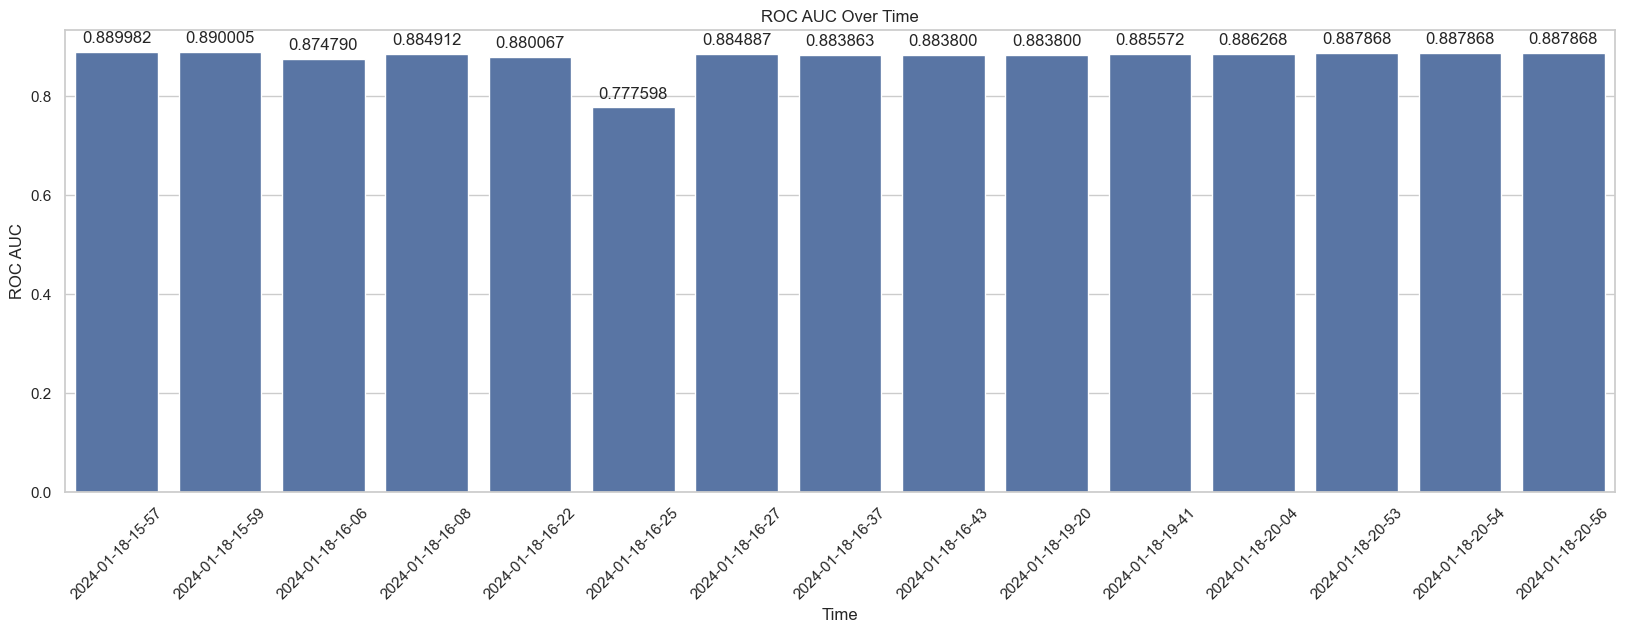

----------------------------------------------------------------------
encoder
catboost
{'iterations': 1000, 'learning_rate': 0.0334, 'depth': 6, 'subsample': 0.49, 'random_strength': 0.00527, 'l2_leaf_reg': 19.32, 'model_size_reg': 12.051}
0.8899819036038054
----------------------------------------------------------------------
age_binning, encoder
catboost
{'iterations': 1000, 'learning_rate': 0.0334, 'depth': 6, 'subsample': 0.49, 'random_strength': 0.00527, 'l2_leaf_reg': 19.32, 'model_size_reg': 12.051}
0.8900045215754551
----------------------------------------------------------------------
age_binning, encoder, scaler, skb
catboost
{'iterations': 1000, 'learning_rate': 0.0334, 'depth': 6, 'subsample': 0.49, 'random_strength': 0.00527, 'l2_leaf_reg': 19.32, 'model_size_reg': 12.051}
0.8747904837669018
----------------------------------------------------------------------
age_binning, encoder, skb
 catboost
{'iterations': 1000, 'learning_rate': 0.0334, 'depth': 6, 'subsample': 0.4

In [609]:
df_log = pd.read_csv('log.csv')
plt.figure(figsize=(20, 6))
ax = sns.barplot(data=df_log, x='Time', y='ROC AUC')
plt.xticks(rotation=45)
plt.title('ROC AUC Over Time')
plt.xlabel('Time')
plt.ylabel('ROC AUC')

# Adding the text on the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.6f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()

for param, pipeline, model, score  in zip(df_log['Params'], df_log['Pipeline'], df_log['Model'], df_log['ROC AUC']):
    print('-'*70)
    print(pipeline)
    print(model)
    print(param)
    print(score)

In [479]:
# Get feature importances
feature_importances = catboost_pipeline.named_steps['catboostclassifier'].get_feature_importance()

# Get feature names from ColumnTransformer
transformed_feature_names = catboost_pipeline.named_steps['pipeline']['encoder'].get_feature_names_out()

# Match importances to feature names
importances_df = pd.DataFrame({
    'Feature': transformed_feature_names,
    'Importance': feature_importances
})

# Sort the dataframe by importance
importances_df.sort_values(by='Importance', ascending=False)

ValueError: All arrays must be of the same length

## Ensemble

### Hyperparameter tuning of weights for ensemble

In [610]:
def objective(trial: Trial, xgboost_pipeline, lgbm_pipeline, hist_pipeline):
    X = train_df[cat_cols+num_cols+['CustomerId']]
    y = train_df['Exited']

    # Suggest weights for the ensemble components
    weight_xgb = trial.suggest_float('xgb_weight', 0.1, 1)
    weight_lgbm = trial.suggest_float('lgbm_weight', 0.1, 1)
    weight_hist = trial.suggest_float('hist_weight', 0.1, 1)

    # Create the ensemble model with the suggested weights
    ensemble_model = VotingClassifier(
        estimators=[
            ('xgb', xgboost_pipeline),
            ('lgbm', lgbm_pipeline),
            ('hist', hist_pipeline),
        ],
        voting='soft',
        weights=[weight_xgb, weight_lgbm, weight_hist]
    )

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    scores = cross_val_score(ensemble_model, X, y, scoring=roc_auc_scorer, cv=skf)

    # Return the mean of the ROC AUC scores
    return np.mean(scores)

In [612]:
study_ensemble = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_ensemble.optimize(lambda trial: objective(trial, xgboost_pipeline, lgbm_pipeline, hist_pipeline), n_trials=20)

[I 2024-01-18 22:04:23,298] A new study created in memory with name: no-name-d0abcaac-983f-462f-8eed-e42365d789f7


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_

[I 2024-01-18 22:05:50,776] Trial 0 finished with value: 0.8890824638865074 and parameters: {'xgb_weight': 0.9476128707220737, 'lgbm_weight': 0.5626673694518467, 'hist_weight': 0.23987315205853274}. Best is trial 0 with value: 0.8890824638865074.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positi

[I 2024-01-18 22:07:10,059] Trial 1 finished with value: 0.8890281342528604 and parameters: {'xgb_weight': 0.3936217014753463, 'lgbm_weight': 0.9401331240740378, 'hist_weight': 0.39003852330410965}. Best is trial 0 with value: 0.8890824638865074.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positi

[I 2024-01-18 22:08:32,131] Trial 2 finished with value: 0.8890102859314114 and parameters: {'xgb_weight': 0.23764585411232053, 'lgbm_weight': 0.5140193842384857, 'hist_weight': 0.6252420621805005}. Best is trial 0 with value: 0.8890824638865074.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positi

[I 2024-01-18 22:09:59,181] Trial 3 finished with value: 0.8890316285223344 and parameters: {'xgb_weight': 0.9870038611323773, 'lgbm_weight': 0.7687139961466076, 'hist_weight': 0.924289191527554}. Best is trial 0 with value: 0.8890824638865074.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positi

[I 2024-01-18 22:11:31,340] Trial 4 finished with value: 0.8889291604103967 and parameters: {'xgb_weight': 0.24601161753223788, 'lgbm_weight': 0.24800836599461784, 'hist_weight': 0.6353232763878843}. Best is trial 0 with value: 0.8890824638865074.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positi

[W 2024-01-18 22:11:39,400] Trial 5 failed with parameters: {'xgb_weight': 0.24325370170272886, 'lgbm_weight': 0.29519821475632324, 'hist_weight': 0.5423559547231966} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/krystianpietrzak/Documents/ML/Kaggle/Kaggle-S4E1/.conda/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/x1/2j32gjvd4v16s6kf306sfdcw0000gn/T/ipykernel_45424/2569802937.py", line 2, in <lambda>
    study_ensemble.optimize(lambda trial: objective(trial, xgboost_pipeline, lgbm_pipeline, hist_pipeline), n_trials=20)
                                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/x1/2j32gjvd4v16s6kf306sfdcw0000gn/T/ipykernel_45424/773533221.py", line 24, in objective
    scores = cross_val_score(ensemble_model, X, y, scoring=roc_auc_scorer, cv=

KeyboardInterrupt: 

In [613]:
best_params_ensemble = {'xgb_weight': 0.9476128707220737, 'lgbm_weight': 0.5626673694518467, 'hist_weight': 0.23987315205853274}
ensemble_model = VotingClassifier(estimators=[
                                                ('xgb', xgboost_pipeline),
                                                ('lgbm', lgbm_pipeline),
                                                ('hist', hist_pipeline),
                                             ], voting='soft', weights = [best_params_ensemble['xgb_weight'], best_params_ensemble['lgbm_weight'], best_params_ensemble['hist_weight']]) 

## Submission

In [584]:
xgboost_pipeline.fit(train_df[cat_cols + num_cols + ['CustomerId']], train_df['Exited'])
test_probabilities = xgboost_pipeline.predict_proba(test_df[cat_cols + num_cols + ['CustomerId']])[:,1]

In [588]:
catboost_pipeline.fit(train_df[cat_cols + num_cols+['CustomerId']], train_df['Exited'])
test_probabilities = catboost_pipeline.predict_proba(test_df[cat_cols + num_cols])[:,1]

CatBoostError: /Users/zomb-ml-platform-msk/go-agent-21.2.0/pipelines/BuildMaster/catboost.git/catboost/private/libs/algo/tensor_search_helpers.cpp:99: This should be unreachable

In [586]:
lgbm_pipeline.fit(train_df[cat_cols + num_cols+['CustomerId']], train_df['Exited'])
test_probabilities = lgbm_pipeline.predict_proba(test_df[cat_cols + num_cols+['CustomerId']])[:,1]

In [614]:
ensemble_model.fit(train_df[cat_cols + num_cols+['CustomerId']], train_df['Exited'])
test_probabilities = ensemble_model.predict_proba(test_df[cat_cols + num_cols+['CustomerId']])[:,1]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 34921, number of negative: 130113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1113
[LightGBM] [Info] Number of data points in the train set: 165034, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211599 -> initscore=-1.315315
[LightGBM] [Info] Start training from score -1.315315
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [615]:
sub = pd.DataFrame()
sub['id'] = test_df['id']
sub['Exited'] = test_probabilities
sub = sub.set_index('id')
sub.head()

,Exited
id,
165034,0.02
165035,0.86
165036,0.03
165037,0.26
165038,0.42


In [616]:
sub.to_csv('submission.csv')